Epoch 1/20
6/6 [==============================] - 13s 1s/step - loss: 94.0733 - accuracy: 0.5053 - val_loss: 8.0927 - val_accuracy: 0.4643
Epoch 2/20
6/6 [==============================] - 7s 1s/step - loss: 4.7428 - accuracy: 0.4842 - val_loss: 1.3247 - val_accuracy: 0.4643
Epoch 3/20
6/6 [==============================] - 9s 1s/step - loss: 0.8009 - accuracy: 0.5947 - val_loss: 0.6454 - val_accuracy: 0.6071
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 0.6142 - accuracy: 0.7105 - val_loss: 0.6303 - val_accuracy: 0.6250
Epoch 5/20
6/6 [==============================] - 7s 1s/step - loss: 0.6340 - accuracy: 0.7083 - val_loss: 0.6451 - val_accuracy: 0.6429
Epoch 6/20
6/6 [==============================] - 9s 1s/step - loss: 0.5961 - accuracy: 0.6842 - val_loss: 0.6638 - val_accuracy: 0.6429
Epoch 7/20
6/6 [==============================] - 8s 1s/step - loss: 0.6116 - accuracy: 0.7000 - val_loss: 0.6013 - val_accuracy: 0.6607
Epoch 8/20
6/6 [=======================

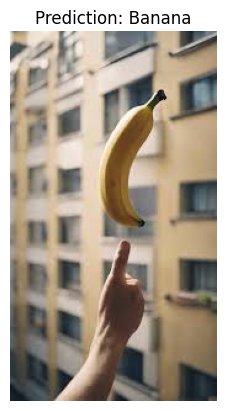

In [28]:

import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Função para carregar e pré-processar imagens
def load_images_from_folder(folder_path, image_size=(128, 128)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertendo de BGR para RGB
            images.append(img)
    return np.array(images)

# Função para carregar e pré-processar uma imagem usando OpenCV
def load_and_preprocess_image(image_path, image_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertendo de BGR para RGB
        img = np.expand_dims(img, axis=0)  # Adicionando uma dimensão para o batch
    return img

# Definir caminhos para os diretórios contendo as imagens
banana_folder_path = '/content/sample_data/Banana'
not_banana_folder_path = '/content/sample_data/Sem banana'

# Carregar e pré-processar as imagens
banana_images = load_images_from_folder(banana_folder_path)
not_banana_images = load_images_from_folder(not_banana_folder_path)

# Criar rótulos
banana_labels = np.ones(len(banana_images))  # Rótulos 1 para bananas
not_banana_labels = np.zeros(len(not_banana_images))  # Rótulos 0 para não bananas

# Concatenar imagens e rótulos
images = np.concatenate((banana_images, not_banana_images), axis=0)
labels = np.concatenate((banana_labels, not_banana_labels), axis=0)

# Dividir dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Aplicar data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Construir modelo CNN com TensorFlow
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Saída binária para banana ou não banana
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=20,
                    validation_data=(X_val, y_val))

# Salvar o modelo treinado
model.save('modelo_bananas_melhorado.h5')

print("Re-treinamento concluído e modelo salvo!")

# Carregar o modelo salvo
model = tf.keras.models.load_model('modelo_bananas_melhorado.h5')

# Caminho da imagem para testar
image_path = '/content/images (17).jpeg'  # Substitua pelo caminho da sua imagem

# Carregar e pré-processar a imagem
image = load_and_preprocess_image(image_path)

# Verificar se a imagem foi carregada corretamente
if image is None:
    raise ValueError("Erro ao carregar a imagem. Verifique se o caminho está correto e a imagem está no formato suportado.")

# Fazer previsão na imagem
prediction = model.predict(image)
prediction = np.round(prediction).flatten()[0]  # Arredondar previsão para 0 ou 1

# Mostrar a imagem e o resultado da previsão
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title(f'Prediction: {"Banana" if prediction == 1 else "Não é Banana"}')
plt.axis('off')
plt.show()

# Caso o modelo erre a previsão
expected_label = 1  # Substitua pelo rótulo correto da imagem (0 para não banana, 1 para banana)
if prediction != expected_label:
    # Adicionar a imagem ao conjunto de treinamento
    if expected_label == 1:
        banana_images = np.append(banana_images, image, axis=0)
        banana_labels = np.append(banana_labels, [1])
    else:
        not_banana_images = np.append(not_banana_images, image, axis=0)
        not_banana_labels = np.append(not_banana_labels, [0])

    # Concatenar imagens e rótulos novamente
    images = np.concatenate((banana_images, not_banana_images), axis=0)
    labels = np.concatenate((banana_labels, not_banana_labels), axis=0)

    # Dividir dados em treino e validação novamente
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Re-treinar o modelo
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch=len(X_train) // 32,
                        epochs=20,
                        validation_data=(X_val, y_val))

    # Salvar o modelo novamente
    model.save('modelo_bananas_melhorado_v2.h5')

    print("Re-treinamento após erro concluído e modelo salvo!")